###  Normalization Layers


| Normalization Type | Key Idea (Analogy) | Normalized Dimensions | Primary Benefit |
| :--- | :--- | :--- | :--- |
| **Batch Norm** | Compares a feature's activation against the **entire batch's** average. | `(N, H, W)` | 🚀 **Faster & stable training** with larger learning rates (needs a decent batch size). |
| **Layer Norm** | Compares a feature's activation against **all other features in the same sample**. | `(C, H, W)` | 🧠 **Batch-size independent**; perfect for RNNs & Transformers. |
| **Instance Norm** | Adjusts the contrast of **each feature map independently**. | `(H, W)` | 🎨 **Removes instance-specific style**; essential for style transfer & generative art. |
| **Group Norm** | A middle ground: normalizes within **groups of channels** for each sample. | `(Group of C, H, W)` | ⚖️ **Stable & effective** when the batch size is too small for Batch Norm. |
| **FRN** | Normalizes each feature map's magnitude **without shifting its average**. | `(H, W)` | ✨ **Excellent performance** across all batch sizes, from 1 to very large. |

### Helper Function to visualize the norm befor and after

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

torch.manual_seed(0)
B, C, H, W = 2, 16, 32, 32

def visualize_norm_effect(before, after, norm_dims):
    """
    Visualize the effect of normalization:
    - Show one representative slice before/after
    - Show histograms separately for normalized vs non-normalized dims
    - Each histogram group uses its own scale
    """
    before = np.array(before.detach().cpu().numpy())
    after  = np.array(after.detach().cpu().numpy())

    all_dims = tuple(range(before.ndim))
    non_norm_dims = tuple(d for d in all_dims if d not in norm_dims)

    # Flatten along normalized vs non-normalized dims
    before_normed = before.mean(axis=non_norm_dims, keepdims=False).flatten() if non_norm_dims else before.flatten()
    after_normed  = after.mean(axis=non_norm_dims, keepdims=False).flatten() if non_norm_dims else after.flatten()

    if non_norm_dims:
        before_non_norm = before.mean(axis=norm_dims, keepdims=False).flatten()
        after_non_norm  = after.mean(axis=norm_dims, keepdims=False).flatten()
    else:
        before_non_norm, after_non_norm = None, None

    # Pick one slice for imshow
    if before.ndim >= 3:
        before_img = before[0, 0]
        after_img  = after[0, 0]
    elif before.ndim == 2:
        before_img, after_img = before, after
    else:
        raise ValueError("Input must be at least 2D for visualization.")

    # Figure layout
    fig, axs = plt.subplots(2, 3 if non_norm_dims else 2, figsize=(14, 5))

    # Before/After images
    im0 = axs[0, 0].imshow(before_img, cmap="gray")
    axs[0, 0].set_title("Before (slice)")
    axs[0, 0].axis("off")
    fig.colorbar(im0, ax=axs[0, 0])

    im1 = axs[1, 0].imshow(after_img, cmap="gray")
    axs[1, 0].set_title("After (slice)")
    axs[1, 0].axis("off")
    fig.colorbar(im1, ax=axs[1, 0])

    # Histograms for normalized dims (independent scale)
    bins_norm = np.linspace(before_normed.min(), before_normed.max(), 80)
    axs[0, 1].hist(before_normed, bins=bins_norm, density=True)
    axs[0, 1].axvline(before_normed.mean(), color="red", linestyle="--")
    axs[0, 1].set_title(f"Before (norm dims {norm_dims})")

    bins_norm_after = np.linspace(after_normed.min(), after_normed.max(), 80)
    axs[1, 1].hist(after_normed, bins=bins_norm_after, density=True)
    axs[1, 1].axvline(after_normed.mean(), color="red", linestyle="--")
    axs[1, 1].set_title(f"After (norm dims {norm_dims})")

    # Histograms for non-normalized dims (independent scale)
    if non_norm_dims:
        bins_non = np.linspace(before_non_norm.min(), before_non_norm.max(), 80)
        axs[0, 2].hist(before_non_norm, bins=bins_non, density=True)
        axs[0, 2].axvline(before_non_norm.mean(), color="red", linestyle="--")
        axs[0, 2].set_title(f"Before (non-norm dims {non_norm_dims})")

        bins_non_after = np.linspace(after_non_norm.min(), after_non_norm.max(), 80)
        axs[1, 2].hist(after_non_norm, bins=bins_non_after, density=True)
        axs[1, 2].axvline(after_non_norm.mean(), color="red", linestyle="--")
        axs[1, 2].set_title(f"After (non-norm dims {non_norm_dims})")

    plt.tight_layout()
    plt.show()

def match_with_torch(torchNorm, customNorm):
    checks = 100
    pass_count = 0
    # check for given iterations and print pass percentage
    for i in range(checks):
        x = torch.rand(B, C, H, W)
        if torch.allclose(torchNorm(x), customNorm(x), rtol=1e-5, atol=1e-6):
            pass_count += 1
    print(f"Matches {pass_count} out of {checks} times")

# Sample Random Input
x = torch.rand(B, C, H, W)


### BatchNorm

Matches 100 out of 100 times


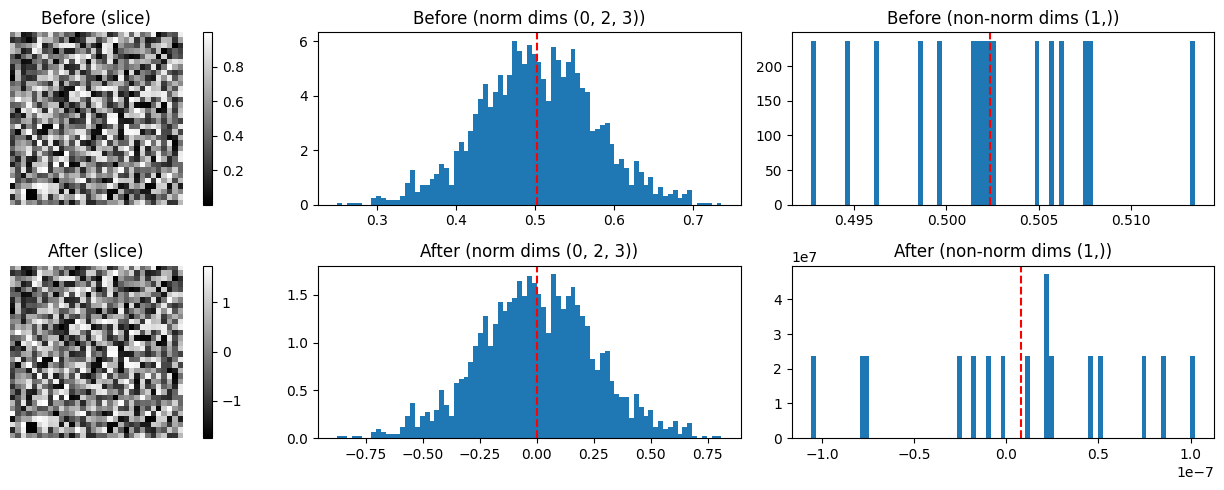

In [2]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        # gamma and beta are learnable parameters if affine is True
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta = nn.Parameter(torch.zeros(num_features))
        else:
            self.gamma = None
            self.beta = None

        # running mean and var are used to track the statistics of the batch
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
        else:
            self.register_buffer('running_mean', None)
            self.register_buffer('running_var', None)

    def forward(self, x):
        assert x.shape[1] == self.num_features, "Input shape does not match num_features"
        # broadcast_shape is used to broadcast the mean and var to the shape of the input
        broadcast_shape = [1, -1] + [1] * (x.dim() - 2)
        # norm_dims is used to normalize the mean and var across the feature dimensions
        norm_dims = (0,) + tuple(range(2, x.dim()))
        # if track_running_stats is True, we need to track the running mean and var
        if self.track_running_stats:
            if self.training:
                mean = x.mean(dim=norm_dims)
                # unbiased=False means divide by N instead of N-1 (just like in pytorch)
                var = x.var(dim=norm_dims, unbiased=False)
                # update the running mean and var
                self.running_mean.mul_(1 - self.momentum).add_(mean.detach() * self.momentum)
                self.running_var.mul_(1 - self.momentum).add_(var.detach() * self.momentum)
            else:
                # if track_running_stats is False, we use the running mean and var
                mean = self.running_mean
                var = self.running_var
        else:
            # if track_running_stats is False, we use the mean and var of the batch
            mean = x.mean(dim=norm_dims)
            var = x.var(dim=norm_dims, unbiased=False)

        # reshape to match the input shape for broadcasting
        mean = mean.view(broadcast_shape)
        var = var.view(broadcast_shape)

        # normalize the input and 1/sqrt = rsqrt (faster than 1/sqrt)
        x = (x - mean) * torch.rsqrt(var + self.eps)
        if self.affine:
            x = self.gamma.view(broadcast_shape) * x + self.beta.view(broadcast_shape)

        return x


match_with_torch(BatchNorm2d(C), nn.BatchNorm2d(C))

visualize_norm_effect(x, BatchNorm2d(C)(x), norm_dims=(0, 2, 3))

### LayerNorm

Matches 100 out of 100 times


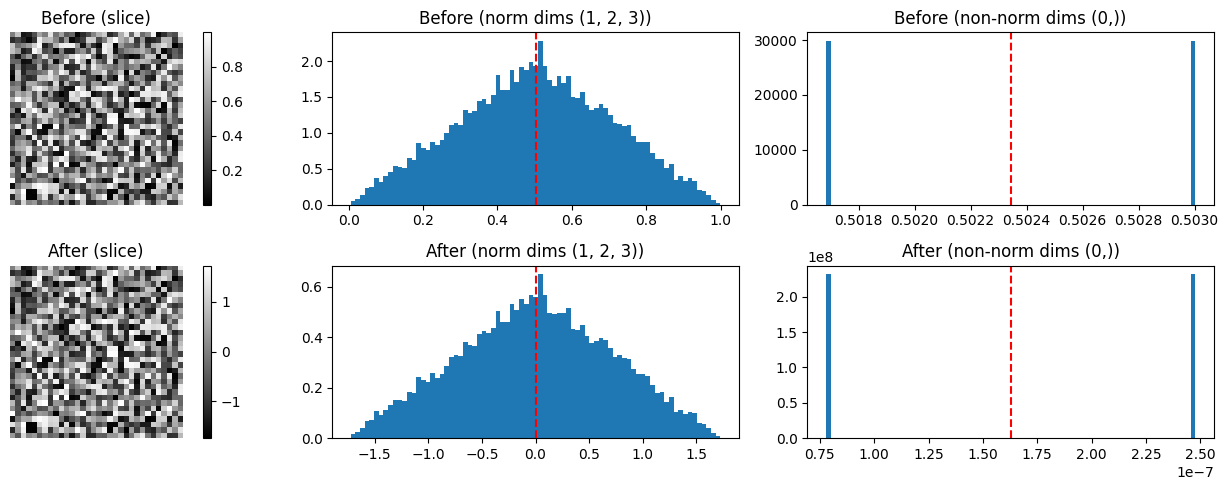

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, normalize_shape, eps=1e-5, elementwise_affine=True, bias=True):
        super().__init__()
        self.normalize_shape = normalize_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        self.bias = bias
        self.gamma = None
        self.beta = None

        if self.elementwise_affine:
            # normalize_shape is a tuple of the dimensions to normalize
            # for example, if normalize_shape is (C, H, W), then the gamma and beta will be of shape (C, H, W)
            self.gamma = nn.Parameter(torch.ones(normalize_shape))
            if bias:
                self.beta = nn.Parameter(torch.zeros(normalize_shape))
            else:
                self.register_parameter('beta', None)
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)

    def forward(self, x):
        # just like pytorch, the normalize_shape should be the last dimensions of the input shape
        assert x.shape[-len(self.normalize_shape):] == self.normalize_shape, "Input shape does not match normalize_shape"

        # Calculate mean and variance across the feature dimensions
        norm_dims = tuple(range(-len(self.normalize_shape), 0))
        # Calculate mean and variance across the feature dimensions
        mean = x.mean(dim=norm_dims, keepdim=True)
        var = x.var(dim=norm_dims, keepdim=True, unbiased=False)

        # Normalize the input
        x = (x - mean) * torch.rsqrt(var + self.eps)
        if self.elementwise_affine:
            x = x * self.gamma
            if self.bias:
                x = x + self.beta
        return x


match_with_torch(LayerNorm((C, H, W)), nn.LayerNorm((C, H, W)))
visualize_norm_effect(x, LayerNorm((C, H, W))(x), norm_dims=(1, 2, 3))

### Instance Normalization

Matches 100 out of 100 times


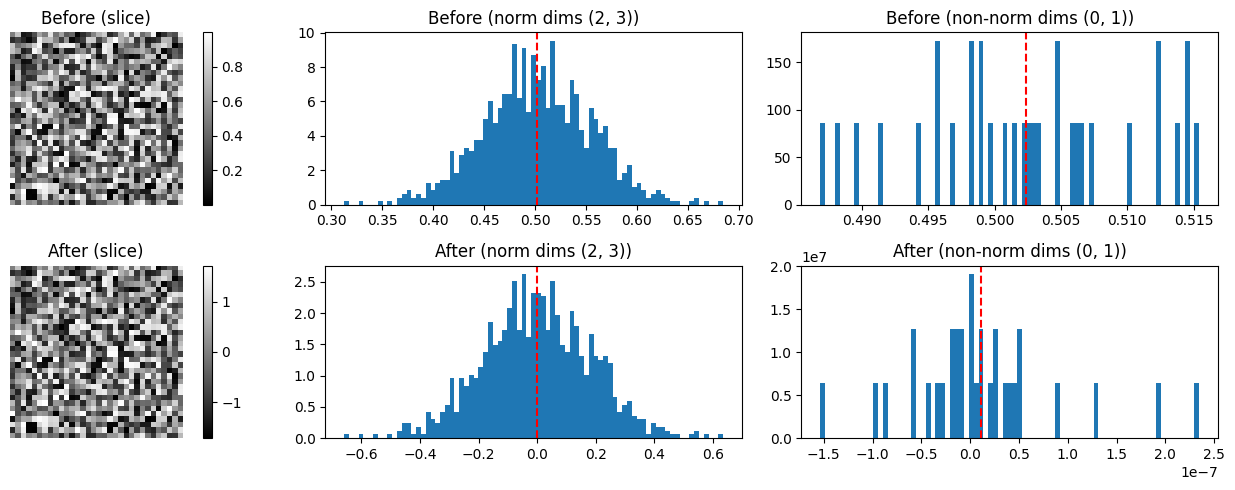

In [4]:
class InstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=False, track_running_stats=False):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
        else:
            self.register_buffer('running_mean', None)
            self.register_buffer('running_var', None)

        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta = nn.Parameter(torch.zeros(num_features))
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)

    def forward(self, x):
        assert x.shape[1] == self.num_features, "Input shape does not match num_features"
        # Normalize per-instance, per-channel across spatial dims only (H, W)
        spatial_dims = tuple(range(2, x.dim()))

        if self.track_running_stats and self.training:
            # Per-instance stats (N, C)
            inst_mean = x.mean(dim=spatial_dims)
            inst_var = x.var(dim=spatial_dims, unbiased=False)
            # Batch aggregate for running stats (C)
            batch_mean = inst_mean.mean(dim=0)
            batch_var = inst_var.mean(dim=0)
            # Update running stats
            self.running_mean.mul_(1 - self.momentum).add_(batch_mean.detach() * self.momentum)
            self.running_var.mul_(1 - self.momentum).add_(batch_var.detach() * self.momentum)
            use_mean = inst_mean
            use_var = inst_var
        elif self.track_running_stats and (not self.training):
            # Use running stats at eval (C)
            use_mean = self.running_mean
            use_var = self.running_var
        else:
            # No running stats: use per-instance stats (N, C)
            use_mean = x.mean(dim=spatial_dims)
            use_var = x.var(dim=spatial_dims, unbiased=False)

        # Broadcast shapes
        if use_mean.dim() == 2:  # (N, C)
            bshape = [x.shape[0], -1] + [1] * (x.dim() - 2)
        else:  # (C,)
            bshape = [1, -1] + [1] * (x.dim() - 2)

        x = (x - use_mean.view(bshape)) * torch.rsqrt(use_var.view(bshape) + self.eps)

        if self.affine:
            wshape = [1, -1] + [1] * (x.dim() - 2)
            x = self.gamma.view(wshape) * x + self.beta.view(wshape)
        return x


match_with_torch(InstanceNorm2d(C), nn.InstanceNorm2d(C))
visualize_norm_effect(x, InstanceNorm2d(C)(x), norm_dims=(2, 3))

### Group Normalization

Matches 100 out of 100 times


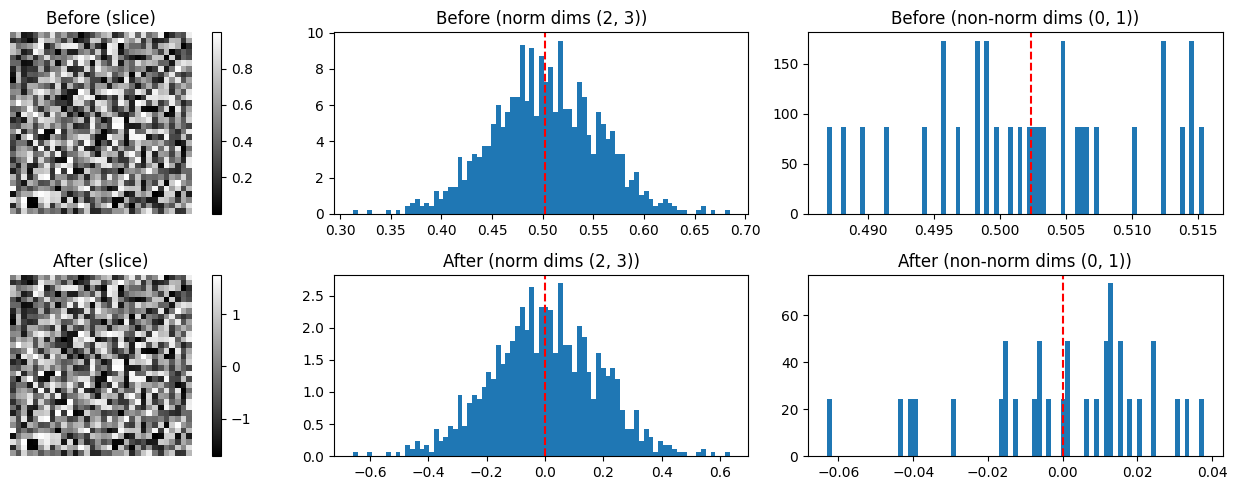

In [5]:
class GroupNorm(nn.Module):
    def __init__(self, num_groups, num_channels, eps=1e-05, affine=True):
        super().__init__()
        assert num_channels % num_groups == 0, "num_channels must be divisible by num_groups"
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_channels))
            self.beta = nn.Parameter(torch.zeros(num_channels))
        else:
            self.register_parameter('gamma', None)
            self.register_parameter('beta', None)

    def forward(self, x):
        B, C, H, W = x.shape
        broadcast_shape = [1, -1] + [1] * (x.dim() - 2)
        assert C % self.num_groups == 0, "num_channels must be divisible by num_groups"
        # reshape to groups, group_size, height, width to calculate mean and var
        x = x.view(B, self.num_groups, -1)
        # calculate mean and var across the group_size dimension
        mean = x.mean(dim=2, keepdim=True)
        var = x.var(dim=2, keepdim=True, unbiased=False)
        # normalize the input
        x = (x - mean) * torch.rsqrt(var + self.eps)
        x = x.view(B, C, H, W)
        if self.affine:
            # reshape to groups, group_size, height, width to broadcast the gamma and beta
            x = self.gamma.view(broadcast_shape) * x + self.beta.view(broadcast_shape)
        # reshape to B, C, H, W
        return x

groups = 4

match_with_torch(GroupNorm(groups, C), nn.GroupNorm(groups, C))
visualize_norm_effect(x, GroupNorm(groups, C)(x), norm_dims=(2, 3))

---